In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gold-price-data/gld_price_data.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from catboost import CatBoostRegressor

In [3]:
df = pd.read_csv("/kaggle/input/gold-price-data/gld_price_data.csv")

In [4]:
print('\nInitial shape:', df.shape)
print('\nColumns:', df.columns.tolist())



Initial shape: (2290, 6)

Columns: ['Date', 'SPX', 'GLD', 'USO', 'SLV', 'EUR/USD']


In [5]:
df.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [6]:
df.columns = [c.strip() for c in df.columns]

In [7]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date').reset_index(drop=True)

In [8]:
print('\nMissing values per column:')
print(df.isna().sum())



Missing values per column:
Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64


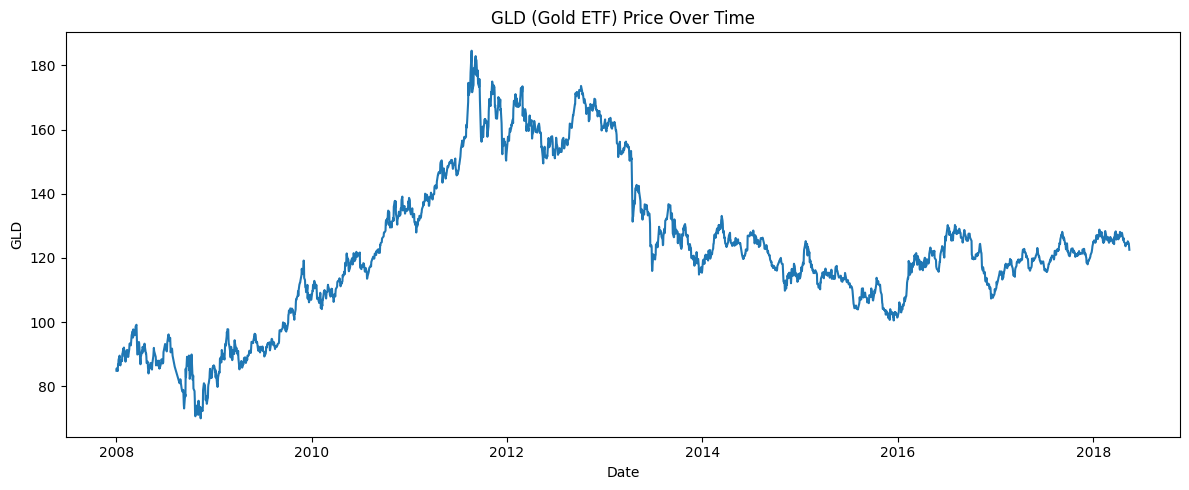

In [9]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['GLD'])
plt.title('GLD (Gold ETF) Price Over Time')
plt.xlabel('Date')
plt.ylabel('GLD')
plt.tight_layout()

plt.show()

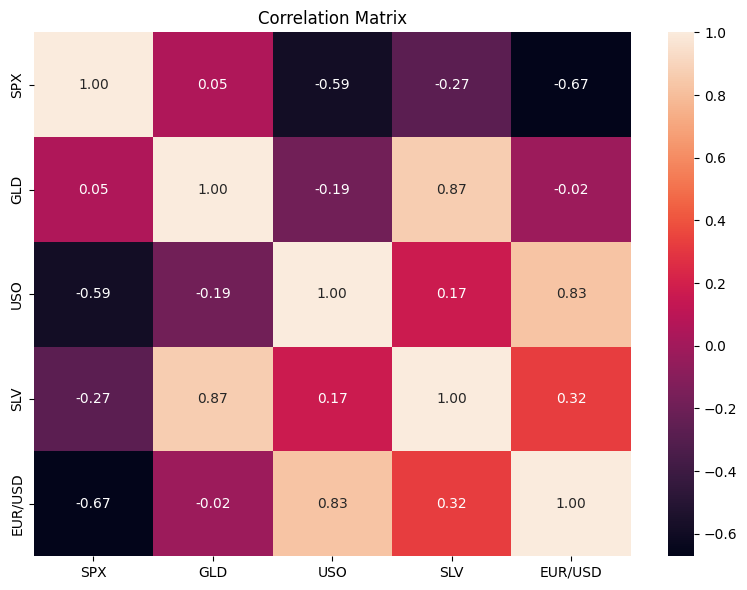

In [10]:
corr = df.drop(columns=['Date']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

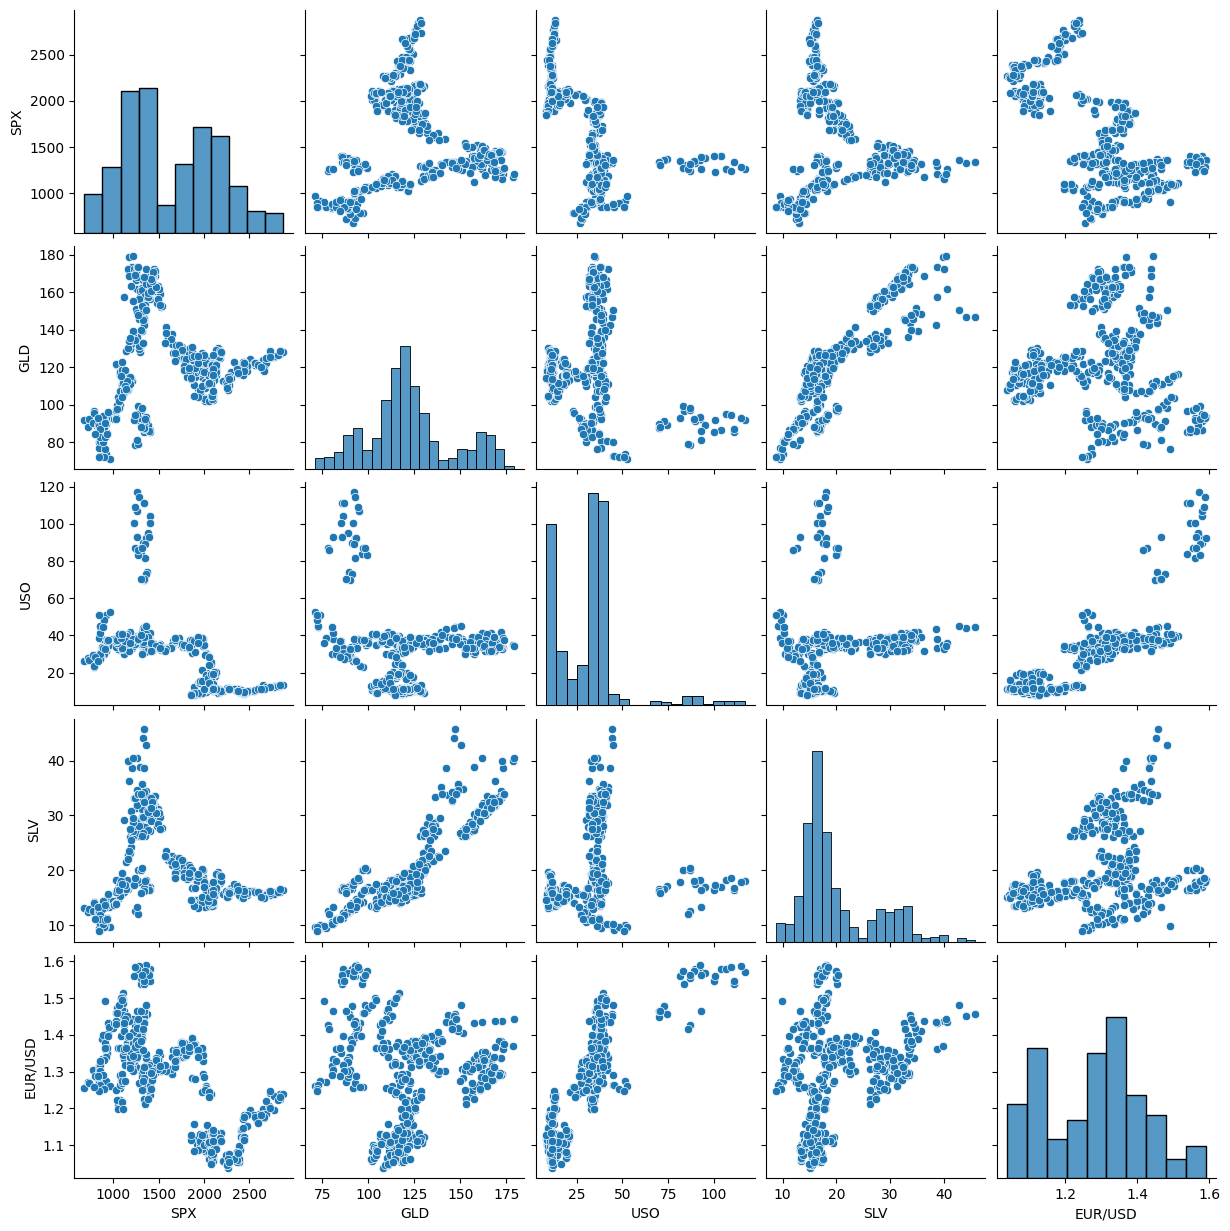

In [11]:
sample = df.sample(n=min(500, len(df)), random_state=42)
sns.pairplot(sample.drop(columns=['Date']))



In [12]:
FEATURE_DF = df.copy()
FEATURE_DF = FEATURE_DF.set_index('Date')

# Create lag features for GLD
for lag in [1,2,3,7,14]:
    FEATURE_DF[f'GLD_lag_{lag}'] = FEATURE_DF['GLD'].shift(lag)

# Create rolling statistics
for window in [3,7,14,30]:
    FEATURE_DF[f'GLD_roll_mean_{window}'] = FEATURE_DF['GLD'].rolling(window).mean()
    FEATURE_DF[f'GLD_roll_std_{window}'] = FEATURE_DF['GLD'].rolling(window).std()

# Percentage change features
FEATURE_DF['GLD_pct_change_1'] = FEATURE_DF['GLD'].pct_change(1)
FEATURE_DF['SPX_pct_change_1'] = FEATURE_DF['SPX'].pct_change(1)
FEATURE_DF['USO_pct_change_1'] = FEATURE_DF['USO'].pct_change(1)
FEATURE_DF['SLV_pct_change_1'] = FEATURE_DF['SLV'].pct_change(1)
FEATURE_DF['EURUSD_pct_change_1'] = FEATURE_DF['EUR/USD'].pct_change(1)

# Drop rows with NaNs created by lags/rolling
FEATURE_DF = FEATURE_DF.dropna().reset_index()

print('\nFeatures created. New shape:', FEATURE_DF.shape)


Features created. New shape: (2261, 24)


In [13]:
FEATURE_DF['target'] = FEATURE_DF['GLD'].shift(-1)  
FEATURE_DF = FEATURE_DF.dropna().reset_index(drop=True)

In [14]:
exclude = ['Date','target']
feature_cols = [c for c in FEATURE_DF.columns if c not in exclude and c!='index']


In [15]:
split_idx = int(len(FEATURE_DF)*0.8)
train_df = FEATURE_DF.iloc[:split_idx]
test_df = FEATURE_DF.iloc[split_idx:]


In [16]:
X_train = train_df[feature_cols]
y_train = train_df['target']
X_test = test_df[feature_cols]
y_test = test_df['target']

print('\nTrain size:', X_train.shape, 'Test size:', X_test.shape)


Train size: (1808, 23) Test size: (452, 23)


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:

def eval_reg(y_true, y_pred, name='Model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return {'mae':mae,'rmse':rmse,'r2':r2}

results = {}

# Baseline: naive forecast (y_t = last observed GLD)
naive_pred = X_test['GLD'].values  # predict today's GLD as tomorrow's
results['naive'] = eval_reg(y_test, naive_pred, 'Naive')

Naive -> MAE: 0.7265, RMSE: 0.9858, R2: 0.9589


In [19]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)
results['linear_regression'] = eval_reg(y_test, lr_pred, 'LinearRegression')

LinearRegression -> MAE: 0.7338, RMSE: 0.9970, R2: 0.9579


In [20]:
rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)  # tree-based models don't need scaling
rf_pred = rf.predict(X_test)
results['random_forest'] = eval_reg(y_test, rf_pred, 'RandomForest')

RandomForest -> MAE: 0.8963, RMSE: 1.1728, R2: 0.9418


In [21]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=30, verbose=False)
xgb_pred = xgbr.predict(X_test)
results['xgboost'] = eval_reg(y_test, xgb_pred, 'XGBoost')

XGBoost -> MAE: 0.8624, RMSE: 1.1270, R2: 0.9463


In [22]:
cat = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=4, verbose=0, random_state=42)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
results['catboost'] = eval_reg(y_test, cat_pred, 'CatBoost')

CatBoost -> MAE: 1.4148, RMSE: 1.7419, R2: 0.8716


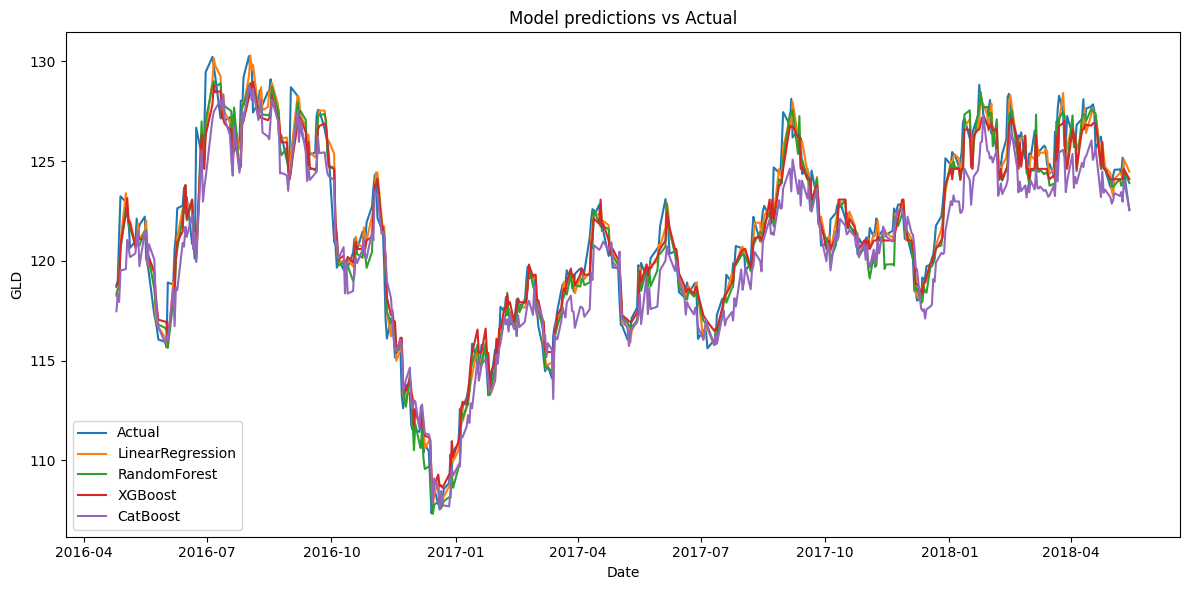

In [23]:
plt.figure(figsize=(12,6))
plt.plot(test_df['Date'], y_test.values, label='Actual')
plt.plot(test_df['Date'], lr_pred, label='LinearRegression')
plt.plot(test_df['Date'], rf_pred, label='RandomForest')
plt.plot(test_df['Date'], xgb_pred, label='XGBoost')
plt.plot(test_df['Date'], cat_pred, label='CatBoost')
plt.legend()
plt.title('Model predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('GLD')
plt.tight_layout()


Evaluation plots saved to outputs/plots/


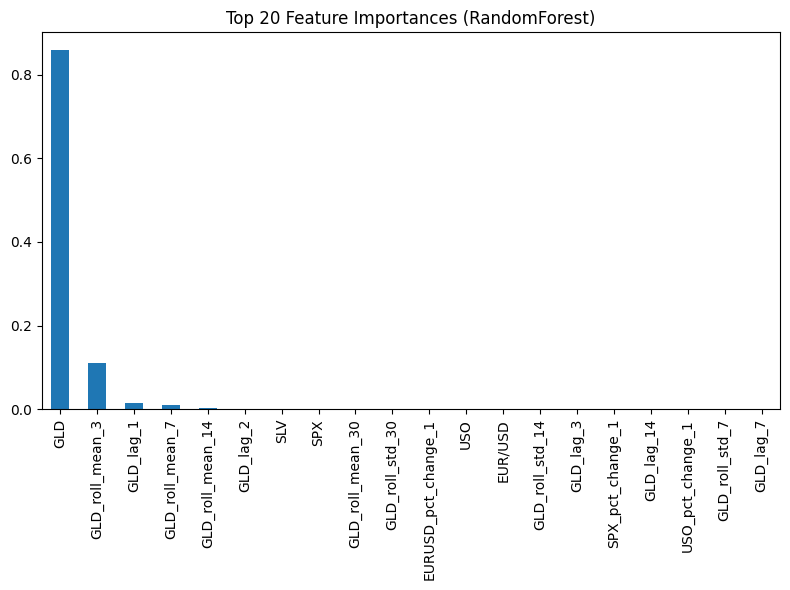

In [24]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_cols).sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
feat_imp.plot(kind='bar')
plt.title('Top 20 Feature Importances (RandomForest)')
plt.tight_layout()
print('\nEvaluation plots saved to outputs/plots/')

In [25]:
print('\nModel summary:')
for k,v in results.items():
    print(k, v)

best_model_name = min(results.items(), key=lambda x: x[1]['mae'])[0]
print(f"\nBest model by MAE: {best_model_name}")



Model summary:
naive {'mae': 0.7265180508849559, 'rmse': 0.9858216008126236, 'r2': 0.9588765611790467}
linear_regression {'mae': 0.7337822673496819, 'rmse': 0.9969522088245459, 'r2': 0.9579426946151255}
random_forest {'mae': 0.8963017266500773, 'rmse': 1.1727879301430293, 'r2': 0.9417988267330493}
xgboost {'mae': 0.8624462980622148, 'rmse': 1.1270042051446234, 'r2': 0.9462542859518946}
catboost {'mae': 1.4147501300749323, 'rmse': 1.7418596862427078, 'r2': 0.8716135767291112}

Best model by MAE: naive
